# Spatial Enrichment Analysis

Spatial transcriptomics technologies yield many molecular readouts
that are hard to interpret by themselves.
One way of summarizing this information is by inferring enrichment
scores from prior knowledge.

In this notebook, we demonstrate how to use `decoupler` to infer
transcription factor (TF) and pathway enrichment scores from a
spatial transcriptomics (Visium) human dataset.

The dataset includes 4k mini-bulk spots from a chronic active multiple sclerosis lesion
{cite:p}`msvisium`. It publicly available at GEO
([GSE279183](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE279183)).

## Loading Packages

In [1]:
import warnings

import scanpy as sc
import decoupler as dc

warnings.filterwarnings("ignore", category=FutureWarning)
sc.set_figure_params(figsize=(3, 3), frameon=False)

## Loading The Dataset

In [2]:
adata = dc.ds.msvisium()
adata

AnnData object with n_obs × n_vars = 3839 × 14940
    obs: 'array_row', 'array_col', 'niches'
    uns: 'spatial'
    obsm: 'spatial'

The obtained {class}`anndata.AnnData` consist of raw integer transcript counts for ~4k
mini-bulk measurements for ~15k genes.

The following step normalizes the data and stores it into a layer for later use.

In [3]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.layers["norm"] = adata.X.copy()

The cell metadata stored in {attr}`anndata.AnnData.obs` can be inspected.

In [4]:
adata.obs

array_row  array_col niches
AAACAAGTATCTCCCA-1         50        102     LC
AAACACCAATAACTGC-1         59         19   PPWM
AAACAGAGCGACTCCT-1         14         94     VI
AAACAGCTTTCAGAAG-1         43          9   PPWM
AAACAGGGTCTATATT-1         47         13   PPWM
...                       ...        ...    ...
TTGTTGTGTGTCAAGA-1         31         77     LC
TTGTTTCACATCCAGG-1         58         42     LR
TTGTTTCATTAGTCTA-1         60         30   PPWM
TTGTTTCCATACAACT-1         45         27   PPWM
TTGTTTGTGTAAATTC-1          7         51     LC

[3839 rows x 3 columns]

The dataset also includes tissue annotations from the original publication:

- GM: Grey Matter
- LC: Lesion Core
- LR: Lesion Rim
- PPWM: PeriPlaque White Matter
- VI: Vascular Infiltrating

The H&E image and the different annotated regions (niches) can be visualized.

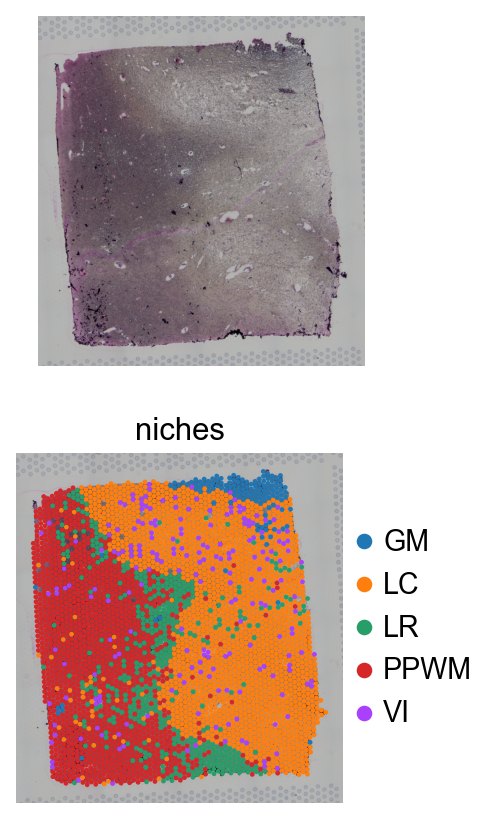

In [5]:
sc.pl.spatial(adata, color=[None, "niches"], size=1.5, ncols=1)

### Spatial Weighting

Spatial data are often sparse. To address this, spatial information
can be leveraged to impute gene expression based on the expression
levels of nearby spatial neighbors {cite:p}`liana`.

This is achieved by generating spatial weights for each spot and
applying them to the gene expression values, effectively smoothing
the data.

In [6]:
dc.pp.knn(adata, key="spatial", bw=100, cutoff=0.1)

The spatial weights assigned to each spot can then be visualized.

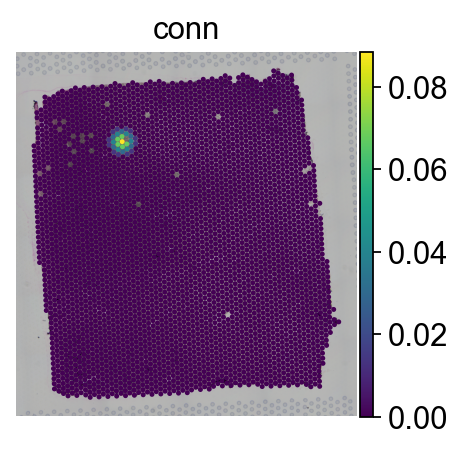

In [7]:
# Plot the spatial weights of one spot
adata.obs["conn"] = adata.obsp["spatial_connectivities"][0].toarray().ravel()
sc.pl.spatial(adata, color="conn", size=1.5)

It can be observed that for a given spot, the spatial weight is maximal
at the spot itself and decreases with increasing distance to other spots.

Adjust the bandwith (`bw`) to increase or decrease the radius to consider.

The gene expression values can now be spatially weighted.

In [8]:
# Update X with spatially weighted gene exression
adata.X = adata.obsp["spatial_connectivities"].dot(adata.X)

The original log-normalized counts can be plotted alongside the newly
spatially transformed values.

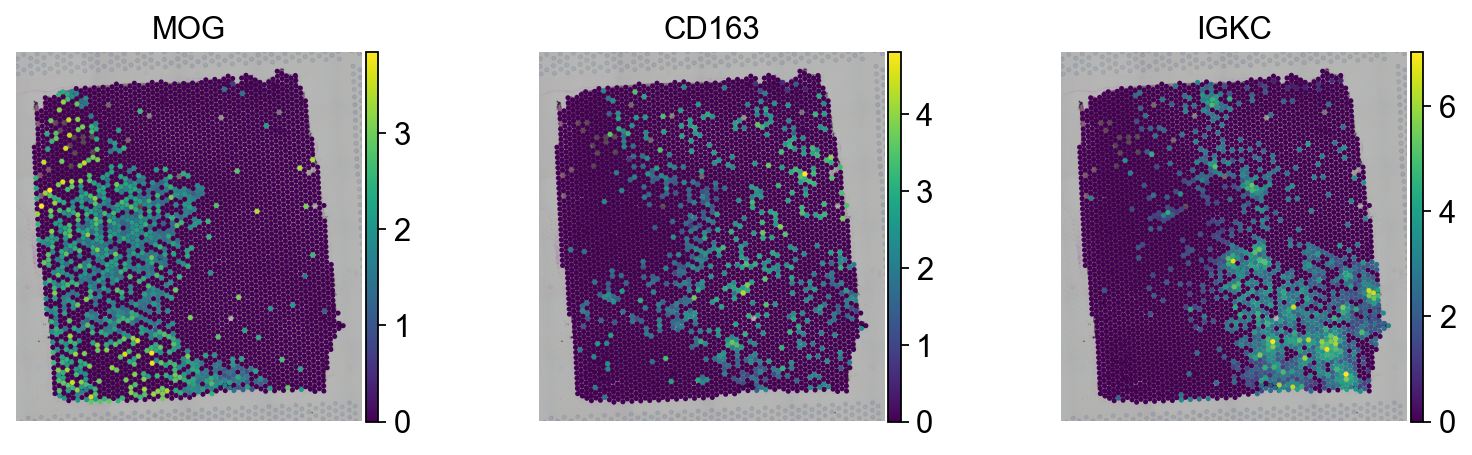

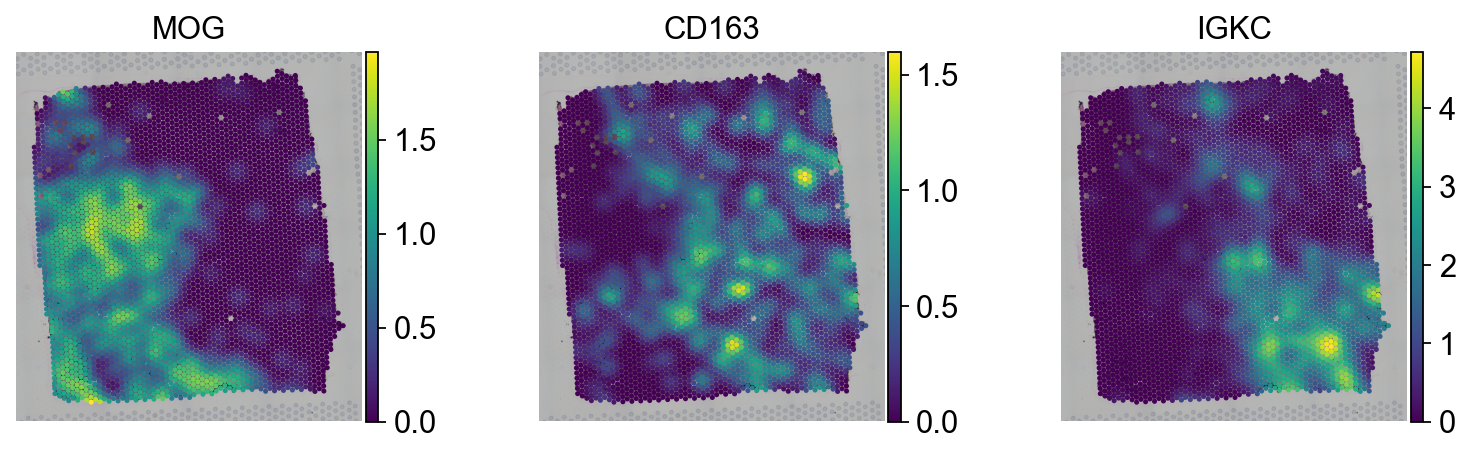

In [9]:
genes = ["MOG", "CD163", "IGKC"]

# Log-normalized counts
sc.pl.spatial(adata, color=genes, size=1.5, layer="norm")

# Spatially weighted gene expression
sc.pl.spatial(adata, color=genes, size=1.5)

After smoothing, spots surrounded by other spots expressing the same gene will
have higher values compared to spots lacking neighboring spots with high values,
even if those spots themselves had high values of expression.

Gene expression for these genes appears to exhibit spatial compartmentalization.

## Enrichment analysis

Enrichment analysis tests whether a specific set of omics features is "overrepresented" or "coordinated"
in the measured data compared to a background distribution. These sets are predefined based on existing
biological knowledge and may vary depending on the omics technology used.

Enrichment analysis requires the use of an enrichment method, and several options are available.
In the original manuscript of `decoupler` {cite:p}`decoupler`, we benchmarked multiple methods
and found that the univariate linear model (`ulm`) outperformed the others. Therefore, we will use
`ulm` in this vignette. 

The scores from {func}`decoupler.mt.ulm` should be interpreted such that larger magnitudes indicate
greater significance, while the sign reflects whether the features in the set are overrepresented
(positive) or underrepresented (negative) compared to the background.

### Transcription factor scoring from gene regulatory networks

Transcription factors (TFs) are genes that, once translated into proteins, bind to DNA and regulate
the expression of other genes by either promoting or inhibiting their transcription. Gene
Regulatory Networks (GRNs) capture these TF-gene interactions and can be constructed from prior
knowledge or inferred from omics data. The fundamental unit of a GRN is a TF and its associated target
genes, collectively known as a *regulon*. Each regulon functions as a gene set in enrichment analysis.

Although TFs are measured in transcriptomic data, their transcript levels often do not reflect their actual
activity in a given cell. Instead, scoring TFs through enrichment analysis based on the expression of
their target genes provides a more accurate representation of their regulatory activity
{cite:p}`grn_review`.

#### CollecTRI network
[CollecTRI](https://github.com/saezlab/CollecTRI) is a comprehensive resource containing a curated
collection of TFs and their transcriptional targets compiled from 12 different resources {cite:p}`collectri`. This collection
provides an increased coverage of transcription factors and a superior performance in identifying perturbed
TFs compared to other literature based GRNs such as 
[DoRothEA](https://saezlab.github.io/dorothea/) {cite:p}`dorothea`.
Similar to DoRothEA, interactions are weighted by their mode of regulation
(activation or inhibition).

In this tutorial we will use the human version but other organisms are available.
We can use `decoupler` to retrieve it from the [OmniPath](https://omnipathdb.org/) server {cite:p}`omnipath`.

<div class="alert alert-info">

**Note**
In this tutorial we use the network CollecTRI, but we could use any other GRN coming from an inference method such as [CellOracle](https://morris-lab.github.io/CellOracle.documentation/), [pySCENIC](https://pyscenic.readthedocs.io/en/latest/) or [SCENIC+](https://scenicplus.readthedocs.io/en/latest/). 
</div> 

In [10]:
collectri = dc.op.collectri(organism="human")
collectri

source          target  weight  \
0         MYC            TERT     1.0   
1        SPI1           BGLAP     1.0   
2       SMAD3             JUN     1.0   
3       SMAD4             JUN     1.0   
4      STAT5A             IL2     1.0   
...       ...             ...     ...   
42985    NFKB  hsa-miR-143-3p     1.0   
42986     AP1     hsa-miR-206     1.0   
42987    NFKB      hsa-miR-21     1.0   
42988    NFKB  hsa-miR-224-5p     1.0   
42989     AP1  hsa-miR-144-3p     1.0   

                                               resources  \
0      DoRothEA-A;ExTRI;HTRI;NTNU.Curated;Pavlidis202...   
1                                                  ExTRI   
2                       ExTRI;NTNU.Curated;TFactS;TRRUST   
3                       ExTRI;NTNU.Curated;TFactS;TRRUST   
4                                                  ExTRI   
...                                                  ...   
42985                                              ExTRI   
42986                          ExTRI;GEREDB;NTNU.Curated   
42987                                              ExTRI   
42988                                              ExTRI   
42989                                              ExTRI   

                                              references       sign_decision  
0      10022128;10491298;10606235;10637317;10723141;1...                PMID  
1                                               10022617  default activation  
2                                      10022869;12374795                PMID  
3                                      10022869;12374795                PMID  
4      10022878;11435608;17182565;17911616;22854263;2...  default activation  
...                                                  ...                 ...  
42985                                           19472311  default activation  
42986                                           19721712                PMID  
42987                                  20813833;22387281  default activation  
42988                                  23474441;23988648  default activation  
42989                                           23546882  default activation  

[42990 rows x 6 columns]

#### Scoring
TF scores can be easily computed by running the `ulm` method.

In [11]:
dc.mt.ulm(data=adata, net=collectri)

Scores can be then extracted as a new `anndata.AnnData` object.

In [12]:
score = dc.pp.get_obsm(adata=adata, key="score_ulm")
score

AnnData object with n_obs × n_vars = 3839 × 660
    obs: 'array_row', 'array_col', 'niches', 'conn'
    uns: 'spatial', 'log1p', 'niches_colors'
    obsm: 'spatial', 'score_ulm', 'padj_ulm'

The obtained scores can be visualized.

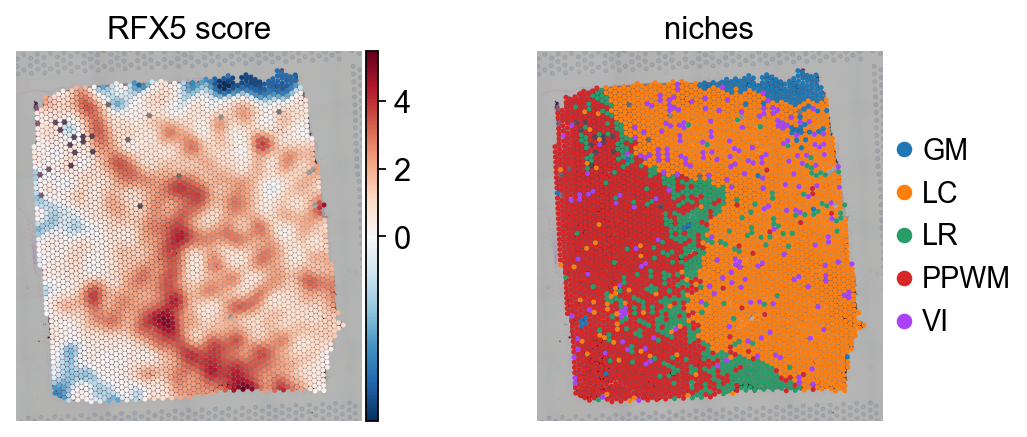

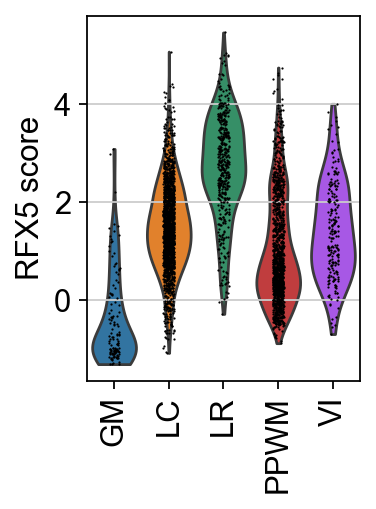

In [13]:
tf = "RFX5"
sc.pl.spatial(score, color=[tf, "niches"], cmap="RdBu_r", vcenter=0, size=1.5, title=[f"{tf} score", "niches"])
sc.pl.violin(score, keys=tf, groupby="niches", rotation=90, ylabel=f"{tf} score")

Here, the TF RFX5, a key regulator for antigen-presenting cells,
exhibits a strong spatial pattern, showing greater activity in the
lesion rim (LR) compared to other areas of the tissue.
This aligns with the known fact that these cells are present in
this region to engulf cellular debris coming from the lesion core.

This can be compared with the actual expression values of the RFX5 gene.

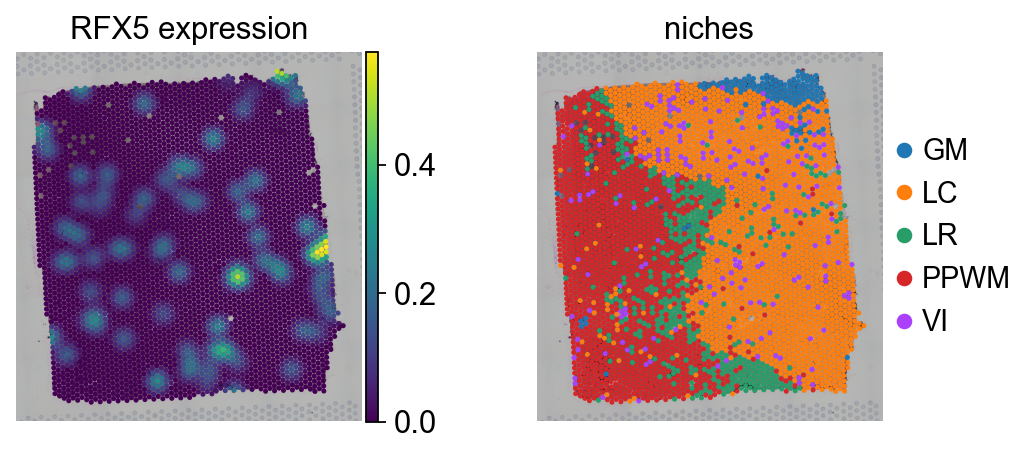

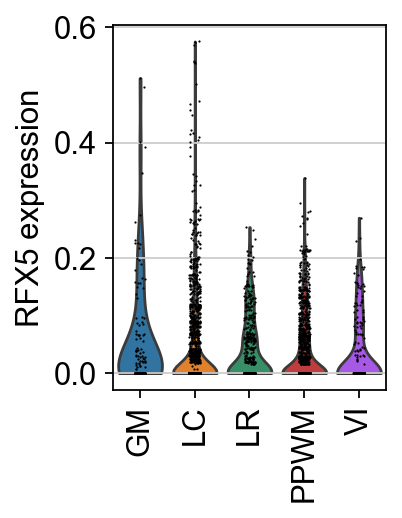

In [14]:
tf = "RFX5"
sc.pl.spatial(adata, color=[tf, "niches"], size=1.5, title=[f"{tf} expression", "niches"])
sc.pl.violin(adata, keys=tf, groupby="niches", rotation=90, ylabel=f"{tf} expression")

When we look at the expression of the TF RFX5 there is no spatial pattern,
as it is randomly expressed across the tissue.

TF expression tends to be sporadic and insufficiently informative to
determine whether a TF is active in a cell,
underscoring the importance of using enrichment scores for
interpreting biological data {cite:p}`grn_review`.

Next, marker TFs for each niche can be identified.

In [15]:
df = dc.tl.rankby_group(adata=score, groupby="niches", reference="rest", method="t-test_overestim_var")
df = df[df["stat"] > 0.0]
df

group reference    name       stat  meanchange      pval      padj
0       LC      rest    SOX2  67.507158    1.769902  0.000000  0.000000
1       LC      rest    LHX2  65.869208    1.727253  0.000000  0.000000
2       LC      rest  POU3F1  58.382363    2.273192  0.000000  0.000000
3       LC      rest   SNAI1  57.754488    1.321344  0.000000  0.000000
4       LC      rest    NFIC  57.671362    1.370289  0.000000  0.000000
...    ...       ...     ...        ...         ...       ...       ...
3289    GM      rest  ARID1A   0.272784    0.012372  0.785291  0.797372
3290    GM      rest  NFE2L2   0.259121    0.022869  0.795821  0.806823
3294    GM      rest   FOXD1   0.168305    0.012613  0.866477  0.873091
3297    GM      rest   KMT2B   0.070595    0.002892  0.943776  0.946644
3299    GM      rest    LHX8   0.016945    0.000832  0.986494  0.986494

[1611 rows x 7 columns]

The top 3 TF markers per niche can then be extracted.

In [16]:
n_markers = 3
source_markers = (
    df.groupby("group")
    .head(n_markers)
    .drop_duplicates("name")
    .groupby("group")["name"]
    .apply(lambda x: list(x))
    .to_dict()
)
source_markers

{'GM': ['ARX', 'NEUROD2', 'EOMES'],
 'LC': ['SOX2', 'LHX2', 'POU3F1'],
 'LR': ['NR1H3', 'RFX5', 'RFXAP'],
 'PPWM': ['SOX10', 'OLIG1', 'NKX2-2'],
 'VI': ['DMTF1', 'SOX18', 'SRF']}

The obtained markers can be plotted

/home/badi/miniforge3/envs/ckc/lib/python3.10/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 660 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


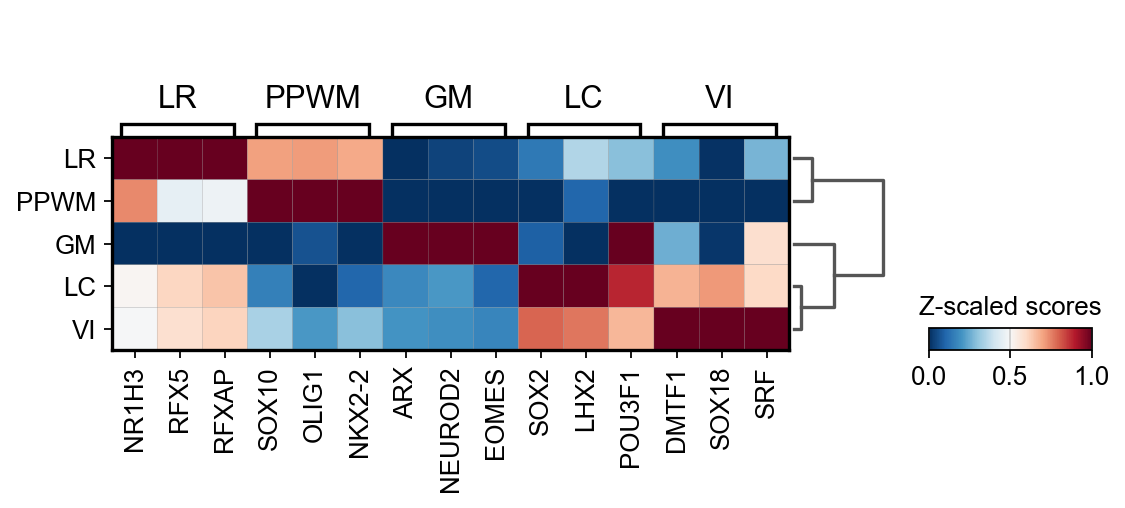

In [17]:
sc.pl.matrixplot(
    adata=score,
    var_names=source_markers,
    groupby="niches",
    dendrogram=True,
    standard_scale="var",
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r",
)

Individual TFs can be examined by plotting their score distributions.

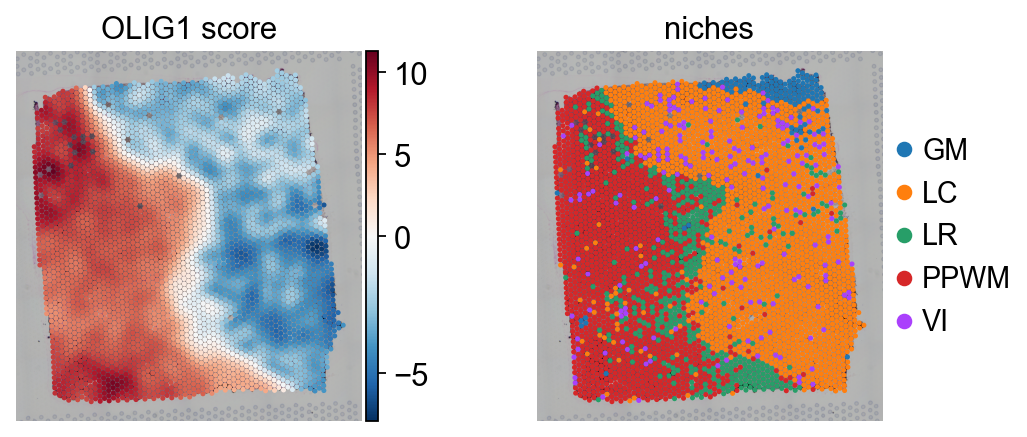

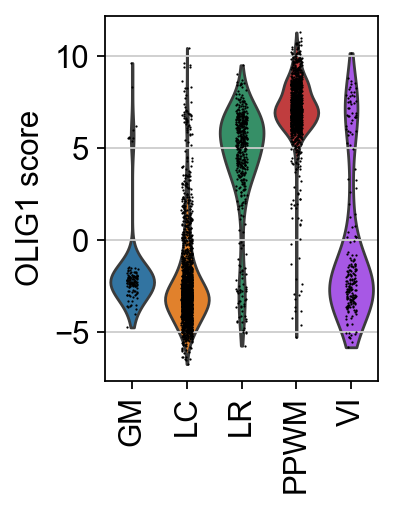

In [18]:
tf = "OLIG1"
sc.pl.spatial(score, color=[tf, "niches"], cmap="RdBu_r", vcenter=0, size=1.5, title=[f"{tf} score", "niches"])
sc.pl.violin(score, keys=[tf], groupby="niches", rotation=90, ylabel=f"{tf} score")

Here, the TF activities for OLIG1 can be observed.
OLIG1 is a known marker TF for oligodendrocytes,
which are present in the PPWM.

### Pathway Scoring

The same approach used for TF scoring can also be applied to pathways. Numerous
databases provide curated pathway gene sets, with one of the most well-known being MSigDB, which
includes several collections {cite:p}`msigdb`. 
These and many other resources can be accessed using the function {func}`decoupler.op.resource`.
To view the list of available databases, use {func}`decoupler.op.show_resources`.

#### PROGENy Pathway Genes
[PROGENy](https://saezlab.github.io/progeny/) is a comprehensive resource that provides a curated
collection of pathways and their target genes, along with weights for each interaction
{cite:p}`progeny`.

Below is a brief description of each pathway:

- **Androgen**: involved in the growth and development of the male reproductive organs
- **EGFR**: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- **Estrogen**: promotes the growth and development of the female reproductive organs
- **Hypoxia**: promotes angiogenesis and metabolic reprogramming when O2 levels are low
- **JAK-STAT**: involved in immunity, cell division, cell death, and tumor formation
- **MAPK**: integrates external signals and promotes cell growth and proliferation
- **NFkB**: regulates immune response, cytokine production and cell survival
- **p53**: regulates cell cycle, apoptosis, DNA repair and tumor suppression
- **PI3K**: promotes growth and proliferation
- **TGFb**: involved in development, homeostasis, and repair of most tissues
- **TNFa**: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection
- **Trail**: induces apoptosis
- **VEGF**: mediates angiogenesis, vascular permeability, and cell migration
- **WNT**: regulates organ morphogenesis during development and tissue repair

This is how to access to it.

In [19]:
progeny = dc.op.progeny(organism="human")
progeny

source   target     weight          padj
0      Androgen  TMPRSS2  11.490631  2.384806e-47
1      Androgen   NKX3-1  10.622551  2.205102e-44
2      Androgen   MBOAT2  10.472733  4.632376e-44
3      Androgen     KLK2  10.176186  1.944410e-40
4      Androgen     SARG  11.386852  2.790210e-40
...         ...      ...        ...           ...
62456       p53    ENPP2   2.771405  4.993215e-02
62457       p53   ARRDC4   3.494328  4.996747e-02
62458       p53    MYO1B  -1.148057  4.997905e-02
62459       p53     CTSC  -1.784693  4.998864e-02
62460       p53    NAA50  -1.435013  4.998884e-02

[62461 rows x 4 columns]

#### Scoring
Pathway scores can be easily computed by running the `ulm` method.

In [20]:
dc.mt.ulm(data=adata, net=progeny)

Scores can be then extracted.

In [21]:
score = dc.pp.get_obsm(adata=adata, key="score_ulm")
score

AnnData object with n_obs × n_vars = 3839 × 14
    obs: 'array_row', 'array_col', 'niches', 'conn'
    uns: 'spatial', 'log1p', 'niches_colors', 'pca', 'dendrogram_niches'
    obsm: 'spatial', 'score_ulm', 'padj_ulm'

And visualized.

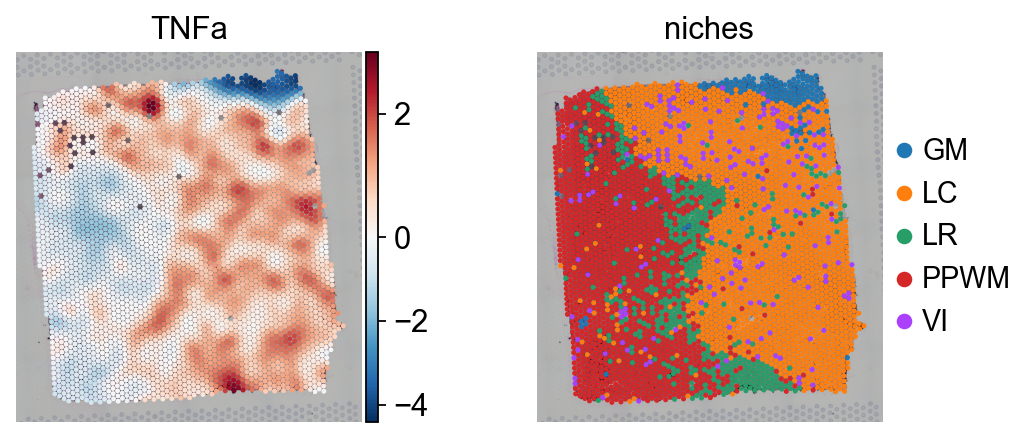

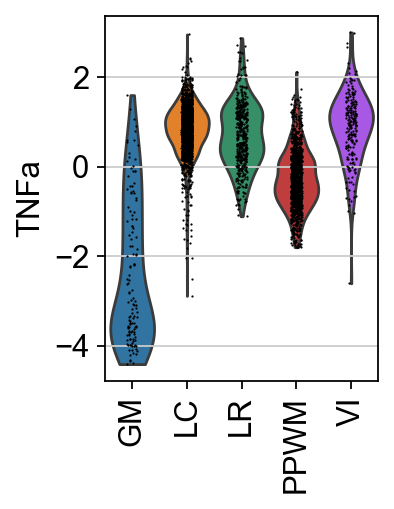

In [22]:
pw = "TNFa"
sc.pl.spatial(score, color=[pw, "niches"], cmap="RdBu_r", vcenter=0, size=1.5)
sc.pl.violin(score, keys=[pw], groupby="niches", rotation=90)

It seem that except in GM and PPWM, the pathway TNF-α,
associated with inflamation, is more active.

Given that there are only 14 pathways, they can be directly
visualized without the need for marker extraction.

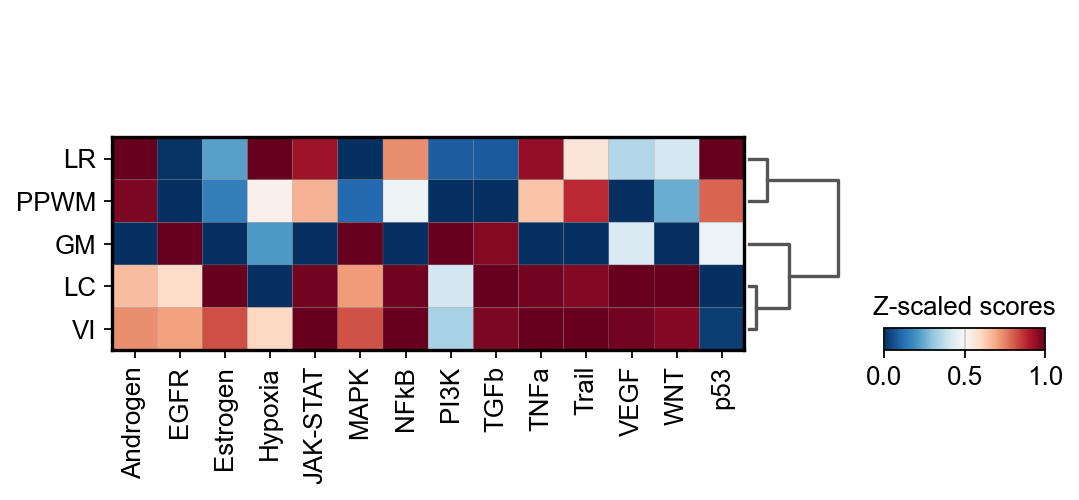

In [23]:
sc.pl.matrixplot(
    adata=score,
    var_names=score.var_names,
    groupby="niches",
    dendrogram=True,
    standard_scale="var",
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r",
)

In this specific example, it can be observed that PI3K is more active in GM,
while Hypoxia is more active in LR.

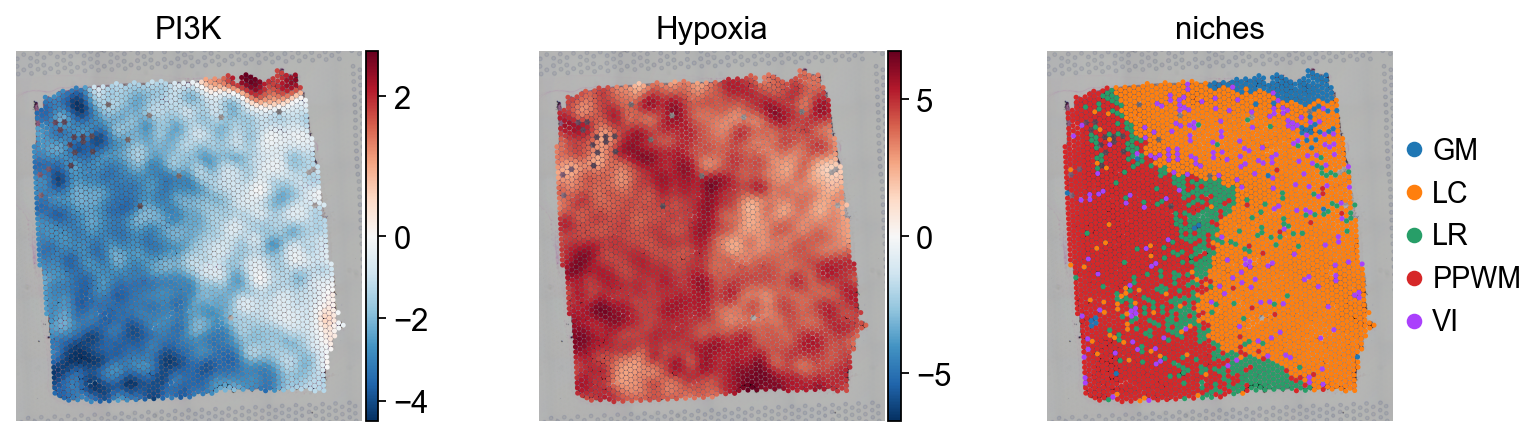

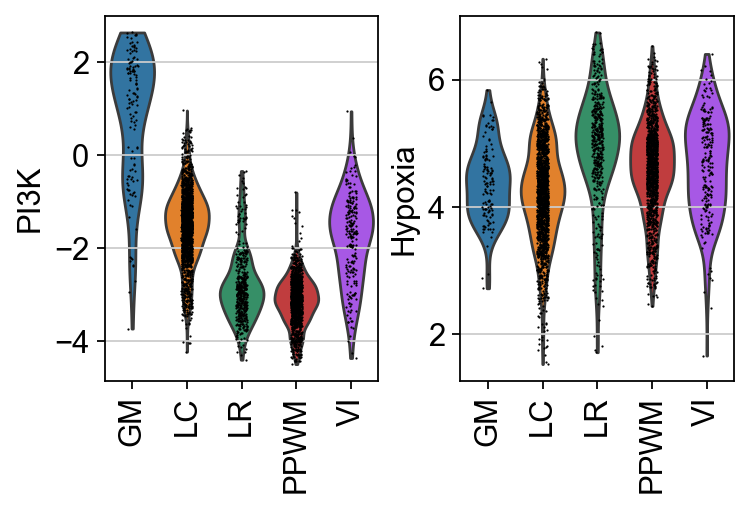

In [24]:
pws = ["PI3K", "Hypoxia"]
sc.pl.spatial(score, color=pws + ["niches"], cmap="RdBu_r", vcenter=0, size=1.5)
sc.pl.violin(score, keys=pws, groupby="niches", rotation=90)

#### Hallmark gene sets
[Hallmark](https://www.gsea-msigdb.org/gsea/msigdb/human/collection_details.jsp#H)
gene sets are curated collections of genes that represent specific, well-defined biological states or processes.
They are part of MSigDB and were developed to reduce redundancy and improve interpretability compared to older,
more overlapping gene set collections {cite:p}`msigdb`.

A total of 50 gene sets are provided, designed to be non-redundant, concise, and biologically coherent.

This is how to access them.

In [25]:
hallmark = dc.op.hallmark(organism="human")
hallmark

source  target
0         IL2_STAT5_SIGNALING    MAFF
1                 COAGULATION    MAFF
2                     HYPOXIA    MAFF
3     TNFA_SIGNALING_VIA_NFKB    MAFF
4                  COMPLEMENT    MAFF
...                       ...     ...
7313      PANCREAS_BETA_CELLS  STXBP1
7314      PANCREAS_BETA_CELLS    ELP4
7315      PANCREAS_BETA_CELLS     GCG
7316      PANCREAS_BETA_CELLS   PCSK2
7317      PANCREAS_BETA_CELLS    PAX6

[7318 rows x 2 columns]

#### Scoring
Pathway scores can be easily computed by running the `ulm` method.

In [26]:
dc.mt.ulm(data=adata, net=hallmark)

Scores can be then extracted.

In [27]:
score = dc.pp.get_obsm(adata=adata, key="score_ulm")
score

AnnData object with n_obs × n_vars = 3839 × 50
    obs: 'array_row', 'array_col', 'niches', 'conn'
    uns: 'spatial', 'log1p', 'niches_colors', 'pca', 'dendrogram_niches'
    obsm: 'spatial', 'score_ulm', 'padj_ulm'

Next, marker gene sets for each niche can be identified.

In [28]:
df = dc.tl.rankby_group(adata=score, groupby="niches", reference="rest", method="t-test_overestim_var")
df = df[df["stat"] > 0]
df

group reference                               name       stat  meanchange  \
0      LC      rest                     UV_RESPONSE_DN  43.795912    1.108682   
7      LC      rest  EPITHELIAL_MESENCHYMAL_TRANSITION  37.059294    1.122682   
9      LC      rest          INTERFERON_GAMMA_RESPONSE  35.737296    1.155296   
10     LC      rest            TNFA_SIGNALING_VIA_NFKB  31.496445    0.661386   
11     LC      rest            ESTROGEN_RESPONSE_EARLY  30.861858    0.660593   
..    ...       ...                                ...        ...         ...   
234    GM      rest                       ADIPOGENESIS   5.733774    0.747548   
236    GM      rest              FATTY_ACID_METABOLISM   5.011884    0.467963   
242    GM      rest                    HEME_METABOLISM   3.116015    0.232688   
243    GM      rest            ESTROGEN_RESPONSE_EARLY   2.888789    0.200897   
245    GM      rest                         DNA_REPAIR   1.536304    0.091333   

              pval           padj  
0     0.000000e+00   0.000000e+00  
7    1.481980e-254  9.262372e-254  
9    5.324817e-230  2.662408e-229  
10   1.507690e-191  6.853138e-191  
11   2.228121e-183  9.283838e-183  
..             ...            ...  
234   2.948604e-08   4.212292e-08  
236   1.070111e-06   1.446096e-06  
242   2.048749e-03   2.382266e-03  
243   4.349467e-03   4.942576e-03  
245   1.258012e-01   1.367405e-01  

[128 rows x 7 columns]

The top 3 set markers per cell type can then be extracted.

In [29]:
n_markers = 3
source_markers = (
    df.groupby("group")
    .head(n_markers)
    .drop_duplicates("name")
    .groupby("group")["name"]
    .apply(lambda x: list(x))
    .to_dict()
)
source_markers

{'GM': ['HEDGEHOG_SIGNALING',
  'PANCREAS_BETA_CELLS',
  'OXIDATIVE_PHOSPHORYLATION'],
 'LC': ['UV_RESPONSE_DN',
  'EPITHELIAL_MESENCHYMAL_TRANSITION',
  'INTERFERON_GAMMA_RESPONSE'],
 'LR': ['COAGULATION', 'COMPLEMENT', 'ALLOGRAFT_REJECTION'],
 'PPWM': ['SPERMATOGENESIS', 'BILE_ACID_METABOLISM', 'ANDROGEN_RESPONSE'],
 'VI': ['TNFA_SIGNALING_VIA_NFKB']}

And plotted.

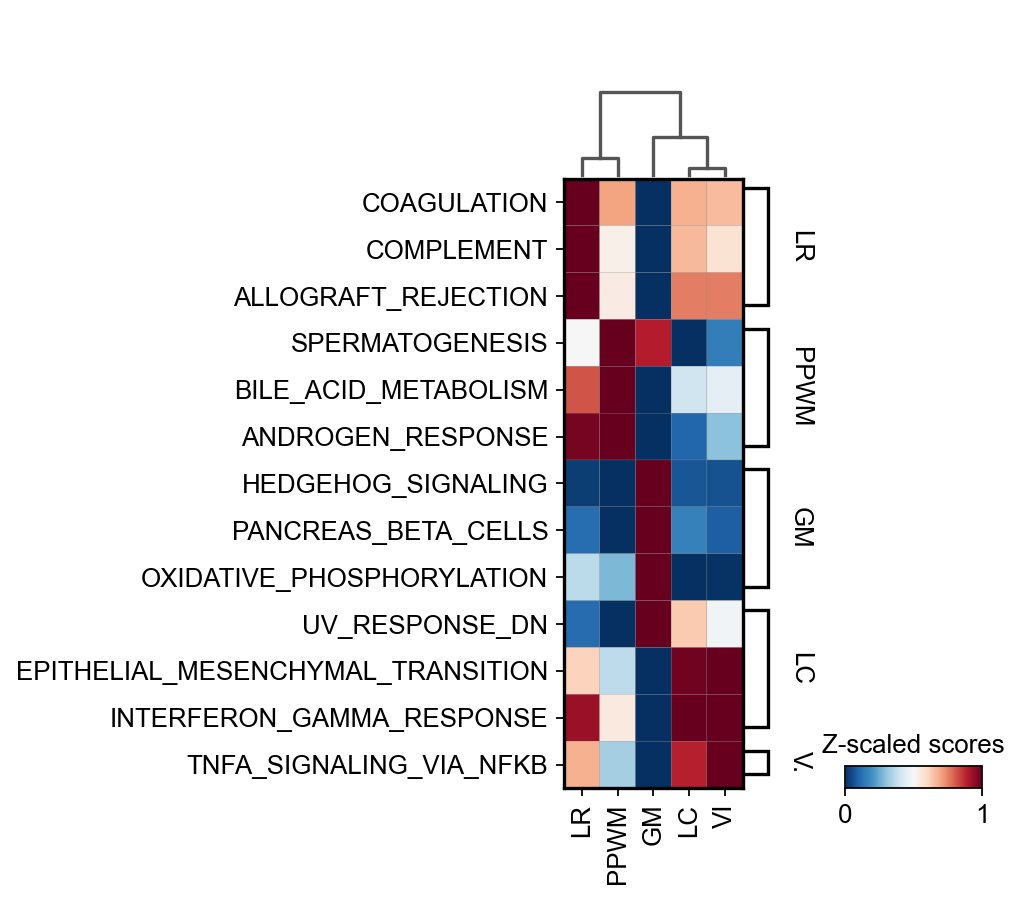

In [30]:
sc.pl.matrixplot(
    adata=score,
    var_names=source_markers,
    groupby="niches",
    dendrogram=True,
    standard_scale="var",
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r",
    swap_axes=True,
)

In this specific example, it can be observed that `HEDGEHOG_SIGNALING` is more active in GM,
while `INTERFERON_GAMMA_RESPONSE` and `TNFA_SIGNALING_VIA_NFKB` are more active in LC and VI.

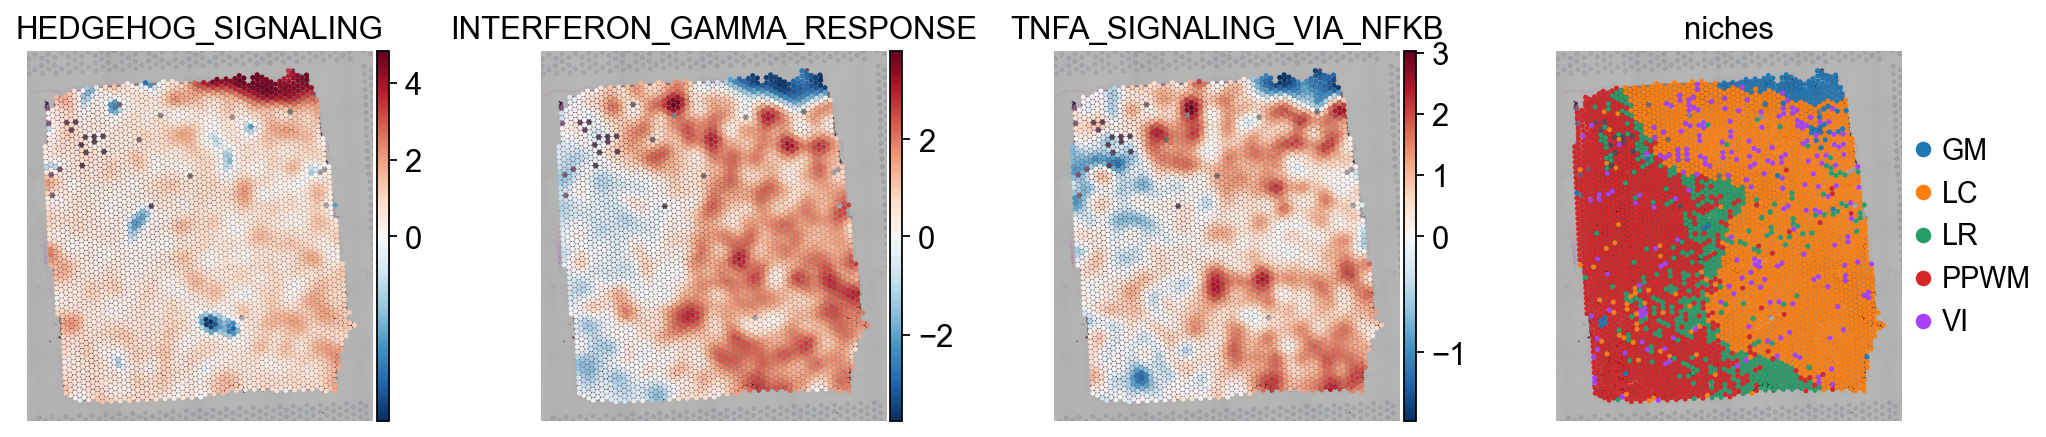

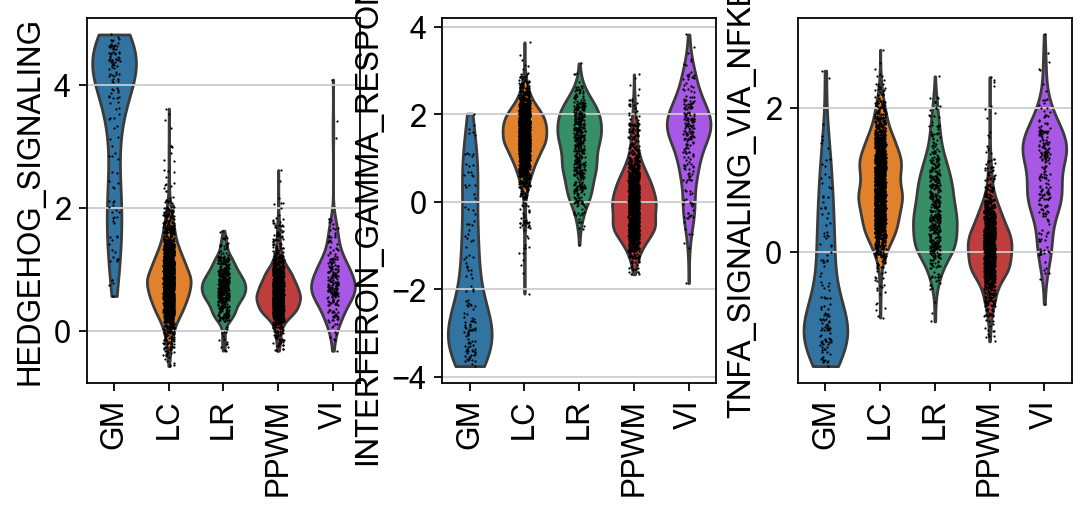

In [31]:
hms = ["HEDGEHOG_SIGNALING", "INTERFERON_GAMMA_RESPONSE", "TNFA_SIGNALING_VIA_NFKB"]
sc.pl.spatial(score, color=hms + ["niches"], cmap="RdBu_r", vcenter=0, size=1.5)
sc.pl.violin(score, keys=hms, groupby="niches", rotation=90)

## References
{bibliography}